In [1]:
import shutil
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import os 
import sys
import matplotlib.pyplot as plt
import pandas as pd
from pyDOE import lhs
%load_ext autoreload
%autoreload 2


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
tfm = tfp.models

In [3]:
# Loading the experimental data
dataexp_path  = './Calibration_testdata/Torsion/obs.dat'                  
dataexp = np.loadtxt(dataexp_path, skiprows =1)
exp_inputs = dataexp[:,:-1].copy()
n_inputs = exp_inputs.shape[1]
exp_outputs = dataexp[:,-1].copy()

In [4]:
print(exp_inputs.shape)

(5, 1)


In [5]:
# Loading the simulator data
datasim_path  = './Calibration_testdata/Torsion/sim.dat'
datasim = np.loadtxt(datasim_path, skiprows =1)
sim_inputs_pars = datasim[:,:-1].copy()
n_pars = sim_inputs_pars.shape[1] - n_inputs
sim_outputs = datasim[:,-1].copy()


In [6]:
print(sim_inputs_pars.shape)

(20, 4)


In [7]:
# Retrieving the labels
f = open(datasim_path, 'r')
labels = f.readline().split('\t')[:-1]
f.close()
print(labels)

['ratio', 'K1', 'K2', 'K3']


In [8]:
model = tfm.Calibration_model(sim_inputs_pars, sim_outputs, exp_inputs, exp_outputs, labels = labels)

In [9]:
sampling_info = model.run_mcmc(mcmc_samples = 5000, estimate_noise = False, warm_up = True)

Noise variance is fixed.
Excecuting the warmup.
Warmup: 
Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.545
Warm-Up Iteration: 1000 Acceptance Rate: 0.524
Warm-Up Iteration: 1500 Acceptance Rate: 0.522
Warm-Up Iteration: 2000 Acceptance Rate: 0.521
Warm-Up Iteration: 2499 Acceptance Rate: 0.524
Sampling in progress.


W0228 18:32:34.097396 139998711850752 deprecation.py:323] From /root/.local/lib/python3.5/site-packages/tensorflow_probability/python/models/bayesgp/scripts/calibration.py:349: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


acceptance_rate: 0.5662


In [10]:
model = tfm.Calibration_model(sim_inputs_pars, sim_outputs, exp_inputs, exp_outputs, labels = labels, sampling_info = sampling_info)

Retrieving hyperparameter samples


In [11]:
path1 = './results/torsion/'

In [12]:
model.plot_chains(path1, path1 )

<Figure size 864x864 with 0 Axes>

In [13]:
main_results, sim_results, disc_results = model.predict(exp_inputs, with_point_samples = True)

In [14]:
mean_pos, std_pos, samples = main_results
mean_posim, std_posim, samplesim = sim_results
mean_poserr, std_poserr, sampleserr = disc_results

In [15]:
lower_sim = np.percentile(samplesim,2.5, axis = 0)
upper_sim = np.percentile(samplesim,97.5, axis = 0)
lower_full = np.percentile(samples,2.5, axis = 0)
upper_full = np.percentile(samples,97.5, axis = 0)
lower_err = np.percentile(sampleserr,2.5, axis = 0)
upper_err = np.percentile(sampleserr,97.5, axis = 0)

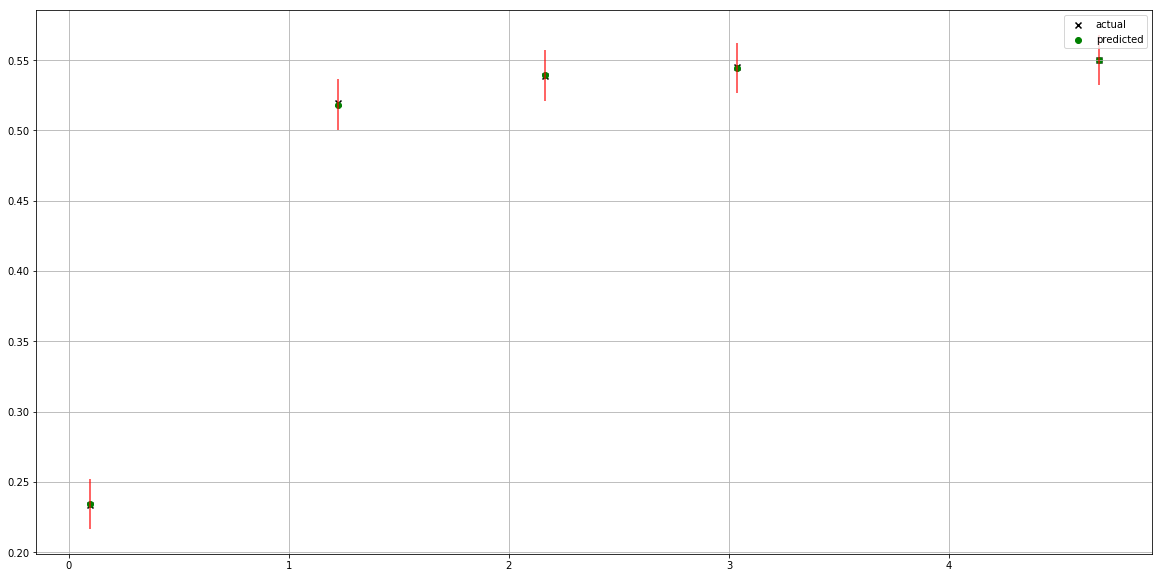

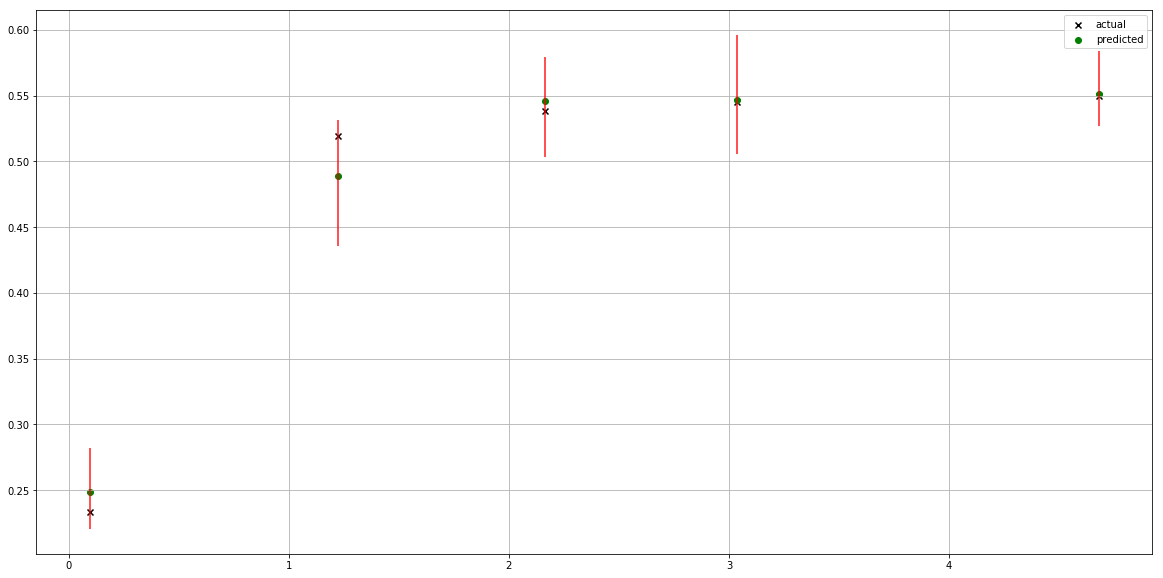

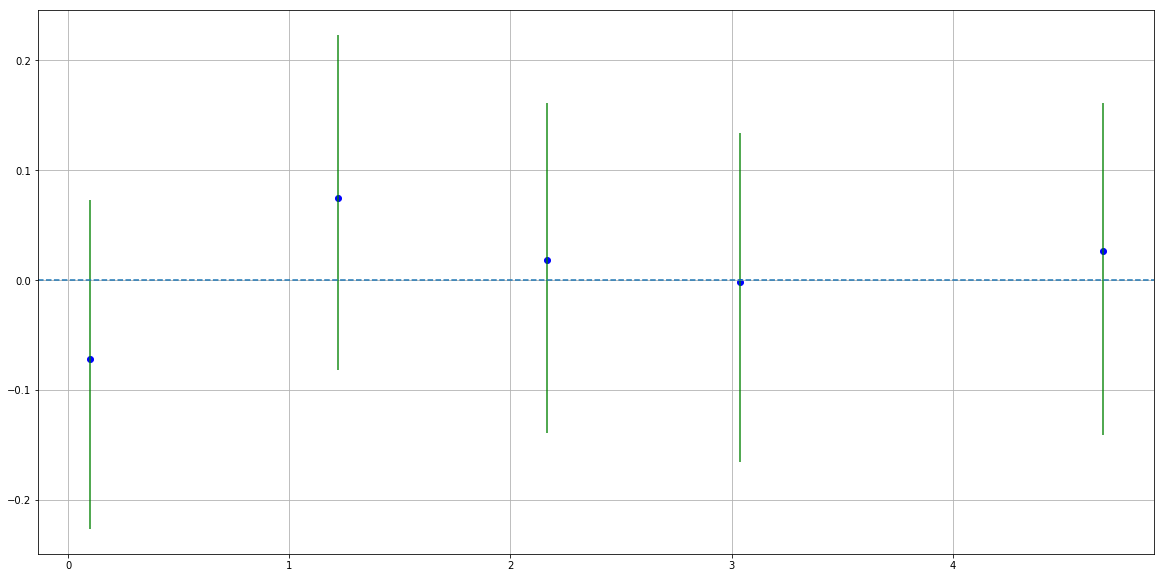

In [16]:
plt.figure(figsize =(20,10))
plt.scatter(exp_inputs[:,0],exp_outputs,marker='x', color = 'black', label = 'actual')
plt.scatter(exp_inputs[:,0], mean_pos, color = 'green', label = 'predicted')
plt.vlines(exp_inputs[:,0], lower_full, upper_full, color = 'red', alpha = 0.8)
plt.grid()
plt.legend()

plt.figure(figsize =(20,10))
plt.scatter(exp_inputs[:,0],exp_outputs,marker='x', color = 'black', label = 'actual')
plt.scatter(exp_inputs[:,0], mean_posim, color = 'green', label = 'predicted')
plt.vlines(exp_inputs[:,0],lower_sim, upper_sim, color = 'red', alpha = 0.9)
plt.grid()
plt.legend()


plt.figure(figsize =(20,10))
plt.scatter(exp_inputs[:,0], mean_poserr, color = 'blue')
plt.vlines(exp_inputs[:,0],lower_err, upper_err, color = 'green', alpha = 0.9)
plt.axhline(y = 0, linestyle ='--')
plt.grid()



In [17]:
path2 = './results/torsion/surfaces/'
main, interaction = model.maineffect_and_interaction(type = 'simulator', directory_path1 = path1, directory_path2 = path2, create_plot = True)

In [18]:
print(interaction.keys())

dict_keys(['ratio || K3', 'K1 || K2', 'K1 || K3', 'ratio || K2', 'ratio || K1', 'K2 || K3'])


In [19]:
Sobol = model.sobol_indices(directory_path = path1, nx_samples = 3000)

Sampling matrix generated


In [20]:
print(Sobol)

{'ratio || K3': 0.0048555136, 'ratio': 0.15763107, 'K2': 0.006101534, 'K1 || K2': 0, 'K1 || K3': 0, 'K1': 0.005452178, 'K3': 0.84947205, 'ratio || K2': 0, 'ratio || K1': 0, 'K2 || K3': 0.0022090077}


In [21]:
Sobol = model.sobol_indices(max_order = 3, nx_samples = 3000, S = Sobol, directory_path = path1)

Initial number of Sobol computations:  14
New number of Sobol computations:  4
Sampling matrix generated


In [22]:
print(Sobol)

{'ratio || K3': 0.0048555136, 'ratio': 0.15763107, 'K1 || K2': 0, 'ratio || K1 || K3': 0.03434252738952637, 'K1': 0.005452178, 'K3': 0.84947205, 'ratio || K2': 0, 'K2 || K3': 0.0022090077, 'ratio || K2 || K3': 0, 'ratio || K1 || K2': 0, 'K2': 0.006101534, 'K1 || K3': 0, 'ratio || K1': 0, 'K1 || K2 || K3': 0}


In [23]:
np.sum(np.array(list(Sobol.values())))

1.060063875745982

In [24]:
Sobol_total = model.total_sobol_indices(nx_samples = 3000, directory_path = path1)

In [25]:
print(Sobol_total)

{'K1': 0.026717842, 'K3': 0.839983, 'ratio': 0.15704209, 'K2': 0.028459728}


In [26]:
np.sum(np.array(list(Sobol_total.values())))

1.0522027